# The 3 E's 

## Using world development indicators to predict PISA scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import re
import textwrap
import warnings
warnings.filterwarnings('ignore')
import csv
import seaborn as sbn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import csv
import seaborn as sbn
%matplotlib inline
from sklearn import linear_model
import math
pd.options.display.float_format = '{:.3f}'.format
from sklearn import preprocessing
sns.set_style('white')
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import statsmodels.api as sm
from sklearn import tree 

In [2]:
Country = pd.read_csv('Country.csv')
CountryNotes = pd.read_csv('CountryNotes.csv')
Footnotes = pd.read_csv('Footnotes.csv')
Indicators = pd.read_csv('Indicators.csv',header = 0,skiprows = range(1,3171013))
Series = pd.read_csv('Series.csv')
SeriesNotes = pd.read_csv('SeriesNotes.csv')
PISA = pd.read_csv('PISA_Combine3.csv')
Region = pd.read_csv('all country.csv')

## First things first, let's clean the data!

#### Let's work on cleaning up our data before we start to model. The 'Indicator' dataset is quite large as it contains indicators for multiple countriest starting in the 1960's. We want to look at the indicators starting in the year 2000 and after. You might have noticed that we added some more code after we imported our csv with the pd.read_csv() funtion. This allows us to keep the column heads (header = 0), and import our 'Indicator' dataset starting at the row dictated by the code. Our imported dataset now starts at the first instance for the year 2000.

In [3]:
Indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,2000,79.537
1,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,2000,65.869
2,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,2000,91.655
3,Arab World,ARB,Access to non-solid fuel (% of population),EG.NSF.ACCS.ZS,2000,81.565
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,2000,78.489


### Merging Datasets

#### I have imported a variety of datasets. In order to be successful with our modeling, I will need to bring in information from the different datasets and merge them into 1 to work off of.

In [4]:
#Rename column name on the 'Region' csv to match the 'Country' csv so that we can merge
region = Region.rename(columns={'alpha-3': 'CountryCode'})

In [5]:
region.columns

Index(['name', 'alpha-2', 'CountryCode', 'country-code', 'iso_3166-2',
       'region', 'sub-region', 'intermediate-region', 'region-code',
       'sub-region-code', 'intermediate-region-code'],
      dtype='object')

#### We will first merge the 'Country' csv with the updated 'region' dataframe.  This will allow us to bring in the region and sub-region information.

In [6]:
countrydf = pd.read_csv('Country.csv')
region_update = region

country_region = countrydf.merge(region, on='CountryCode')

#### Let's merge our new 'country_region' dataframe with the PISA information now.

In [7]:
country_main = country_region
pisadf = pd.read_csv("PISA_Combine3.csv")

combine = country_main.merge(pisadf, on="CountryCode")

#### As a final merge, we will now combine our updated 'combine' dataframe with the indicator data so that we can work through some models.

In [8]:
indicatordf = pd.read_csv("Indicators.csv")
main = combine.merge(indicatordf, on=['Year','CountryCode'])

In [9]:
main.columns

Index(['CountryCode', 'ShortName', 'TableName', 'LongName', 'Alpha2Code',
       'CurrencyUnit', 'SpecialNotes', 'Region', 'IncomeGroup', 'Wb2Code',
       'NationalAccountsBaseYear', 'NationalAccountsReferenceYear',
       'SnaPriceValuation', 'LendingCategory', 'OtherGroups',
       'SystemOfNationalAccounts', 'AlternativeConversionFactor',
       'PppSurveyYear', 'BalanceOfPaymentsManualInUse',
       'ExternalDebtReportingStatus', 'SystemOfTrade',
       'GovernmentAccountingConcept', 'ImfDataDisseminationStandard',
       'LatestPopulationCensus', 'LatestHouseholdSurvey',
       'SourceOfMostRecentIncomeAndExpenditureData',
       'VitalRegistrationComplete', 'LatestAgriculturalCensus',
       'LatestIndustrialData', 'LatestTradeData', 'LatestWaterWithdrawalData',
       'name', 'alpha-2', 'country-code', 'iso_3166-2', 'region', 'sub-region',
       'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code', 'Year', 'Jurisdiction', 'Average',
      

#### For project purposes, I will create a copy of my fully merged dataset.  This is being done in the event that I need to refer back to the original version.

In [10]:
project = main.copy()

#### There are a lot of columns present that we don't need for our analysis.  Let's drop them.

In [11]:
project.drop(["ShortName","LongName","Alpha2Code","Wb2Code","SnaPriceValuation","SpecialNotes","Region","intermediate-region-code","sub-region-code","VitalRegistrationComplete","LatestAgriculturalCensus",
                    "LatestIndustrialData","LatestTradeData","LatestWaterWithdrawalData","SourceOfMostRecentIncomeAndExpenditureData",
                    "LatestHouseholdSurvey","LatestPopulationCensus","ImfDataDisseminationStandard","GovernmentAccountingConcept","intermediate-region",
                    "NationalAccountsBaseYear", "NationalAccountsReferenceYear", "LendingCategory", "OtherGroups", "SystemOfNationalAccounts",
                    "AlternativeConversionFactor", "PppSurveyYear", "BalanceOfPaymentsManualInUse", "ExternalDebtReportingStatus",
                    "region-code", "TableName","alpha-2","iso_3166-2","Jurisdiction" ], axis = 1, inplace = True) 

#### What do our columns look like now?

In [12]:
project.columns

Index(['CountryCode', 'CurrencyUnit', 'IncomeGroup', 'SystemOfTrade', 'name',
       'country-code', 'region', 'sub-region', 'Year', 'Average',
       'Standard Error', 'Area', 'CountryName', 'IndicatorName',
       'IndicatorCode', 'Value'],
      dtype='object')

In [13]:
project.rename(columns = {'CountryCode':'Country Code Alpha', 'CurrencyUnit':'Currency Unit', 
                          'IncomeGroup':'Income Group', 'SystemofTrade':'System of Trade','name':'Country',
                          'country-code':'Country Code Numeric','region':'Region','sub-region':'Sub Region', 
                          'Average':'PISA Score Average','Standard Error':'PISA Score Standard Error','Area':'Subject',
                          'IndicatorName':'Indicator Name','Indicator Code':'IndicatorCode','Value':'IndicatorCodeValue'}, inplace = True)

In [14]:
project.head(1)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
0,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2015,nan,nan,Math,Albania,Bank capital to assets ratio (%),FB.BNK.CAPA.ZS,9.700


#### Let's get an idea of how much of the data is null.  This will allow us to scrub our dataset further.  We can do this a couple of ways.

#### First Option:  What is the percentage of null for each column in my dataframe?

In [15]:
project.isnull().sum()/len(project)*100

Country Code Alpha           0.000
Currency Unit                0.000
Income Group                 0.000
SystemOfTrade                0.000
Country                      0.000
Country Code Numeric         0.000
Region                       0.000
Sub Region                   0.000
Year                         0.000
PISA Score Average          38.899
PISA Score Standard Error   38.899
Subject                      0.000
CountryName                  0.000
Indicator Name               0.000
IndicatorCode                0.000
IndicatorCodeValue           0.000
dtype: float64

#### Second option:  What are the counts of the nulls for each column in my dataframe?

In [16]:
project.isnull().sum(axis=0)

Country Code Alpha                0
Currency Unit                     0
Income Group                      0
SystemOfTrade                     0
Country                           0
Country Code Numeric              0
Region                            0
Sub Region                        0
Year                              0
PISA Score Average           297153
PISA Score Standard Error    297153
Subject                           0
CountryName                       0
Indicator Name                    0
IndicatorCode                     0
IndicatorCodeValue                0
dtype: int64

#### We can see that the columns of 'PISA Score Average' and 'PISA Standard Error' are the only 2 that contain null values.  We are looking at PISA scores for countries for 6 different years.  This is telling us that not all countries have scores for all of the years.  We need to keep this in mind as we work through the data for modeling.

In [17]:
project.Year.unique()

array([2015, 2006, 2003, 2000, 2012, 2009])

In [18]:
project.Subject.unique()

array(['Math', 'Reading', 'Science'], dtype=object)

#### #Create new columns based on new features to identify the different PISA subjects as binary output.

In [19]:
#Can also do project.Subject=="Math" as an option, but we will proceed with how I have it written below.
project['subject_math'] = np.where(project.Subject.str.startswith('Math'), 1,0)
project['subject_reading']= np.where(project.Subject.str.startswith('Reading'), 1,0)
project['subject_science']= np.where(project.Subject.str.startswith('Science'), 1,0)

### Indicator Picklist

#### The data contains multiple indicators that are broken out by country as well as year.  For the purpose of my project, I am choosing to focus on 3 of them.  Let's create a picklist so that we are able to filter out the codes that we need.

#### The 3 indicators that I will be focusing are below:
* Education
* Economy
* Employment

In [20]:
indicators = Indicators['IndicatorName'].unique().tolist()
indicators.sort()

In [21]:
indicators_list = Indicators[['IndicatorName','IndicatorCode']].drop_duplicates().values

In [22]:
indicators_list

array([['Access to electricity (% of population)', 'EG.ELC.ACCS.ZS'],
       ['Access to electricity, rural (% of rural population)',
        'EG.ELC.ACCS.RU.ZS'],
       ['Access to electricity, urban (% of urban population)',
        'EG.ELC.ACCS.UR.ZS'],
       ...,
       ['Fish species, threatened', 'EN.FSH.THRD.NO'],
       ['Mammal species, threatened', 'EN.MAM.THRD.NO'],
       ['Plant species (higher), threatened', 'EN.HPT.THRD.NO']],
      dtype=object)

In [23]:
new_indicators =[]
indicators_code =[]

for ind in indicators_list:
    indicator = ind[0]
    code = ind[1].strip()
    if code not in indicators_code:
        #Delete ,() from indicators and convert all characters to lower case
        modified_indicator = re.sub('[,()]',"",indicator).lower()
        #Replace - with "to"
        modified_indicator = re.sub('-'," to ",modified_indicator).lower()
        new_indicators.append([modified_indicator,code])
        indicators_code.append(code)

In [24]:
Indicators = pd.DataFrame(new_indicators, columns=['IndicatorName','IndicatorCode'])
Indicators = Indicators.drop_duplicates()
print(Indicators.shape)

(1344, 2)


In [25]:
key_word_dict = {}

key_word_dict['Economy'] = ['income','gdp']
key_word_dict['Education'] = ['literacy','enrolment']
key_word_dict['Employment'] =['employed','employment','umemployed','unemployment']

#### Using the key word dictionary we created above, let's create a way to see all the different features under a keyword.

In [26]:
def pick_indicator(feature):
   
    indicator_name = []
    
    for indicator_ele in Indicators.values:
        
        if feature not in key_word_dict.keys():
            print("Choose the right feature!")
            break
        
        for word in key_word_dict[feature]:
            
            word_list = indicator_ele[0].split() # it would split from ','
            
            if word in word_list or word+'s' in word_list:
                
                print(indicator_ele[1])
                
                indicator_name.append(indicator_ele[1])
                
                break
                
    return indicator_name

#### We now have the ability to use the pick_indicator function in order to see the list of indicators for a chosen group.  Let's set a line of code for each of the 3 E's.

In [27]:
education = pick_indicator('Education')

SE.PRM.TENR
SE.PRM.TENR.FE
SE.PRM.TENR.MA
SE.ADT.LITR.ZS
SE.ADT.LITR.FE.ZS
SE.ADT.LITR.MA.ZS
SE.PRM.ENRL
SE.SEC.ENRL
SE.SEC.ENRL.GC
SE.SEC.ENRL.VO
SE.PRE.ENRR
SE.PRE.ENRR.FE
SE.PRE.ENRR.MA
SE.ENR.PRSC.FM.ZS
SE.PRM.ENRR
SE.PRM.ENRR.FE
SE.ENR.PRIM.FM.ZS
SE.PRM.ENRR.MA
SE.SEC.ENRR
SE.SEC.ENRR.FE
SE.ENR.SECO.FM.ZS
SE.SEC.ENRR.MA
SE.TER.ENRR
SE.TER.ENRR.FE
SE.ENR.TERT.FM.ZS
SE.TER.ENRR.MA
SE.PRM.NENR
SE.PRM.NENR.FE
SE.PRM.NENR.MA
SE.SEC.NENR
SE.SEC.NENR.FE
SE.SEC.NENR.MA
SE.PRM.PRIV.ZS
SE.SEC.PRIV.ZS
SE.ADT.1524.LT.ZS
SE.ADT.1524.LT.FE.ZS
SE.ADT.1524.LT.FM.ZS
SE.ADT.1524.LT.MA.ZS


In [28]:
employment = pick_indicator('Employment')
economy = pick_indicator('Economy')

SL.EMP.TOTL.SP.FE.ZS
SL.EMP.TOTL.SP.MA.ZS
SL.EMP.TOTL.SP.ZS
SL.EMP.1524.SP.FE.ZS
SL.EMP.1524.SP.MA.ZS
SL.EMP.1524.SP.ZS
SL.GDP.PCAP.EM.KD
SL.UEM.TOTL.FE.ZS
SL.UEM.TOTL.FE.NE.ZS
SL.UEM.TOTL.MA.ZS
SL.UEM.TOTL.MA.NE.ZS
SL.UEM.TOTL.ZS
SL.UEM.TOTL.NE.ZS
SL.UEM.1524.FE.ZS
SL.UEM.1524.MA.ZS
SL.UEM.1524.ZS
SL.FAM.WORK.FE.ZS
SL.FAM.WORK.MA.ZS
SL.FAM.WORK.ZS
SL.EMP.MPYR.FE.ZS
SL.EMP.MPYR.MA.ZS
SL.EMP.MPYR.ZS
SL.AGR.EMPL.ZS
SL.AGR.EMPL.FE.ZS
SL.AGR.EMPL.MA.ZS
SL.IND.EMPL.ZS
SL.IND.EMPL.FE.ZS
SL.IND.EMPL.MA.ZS
SL.SRV.EMPL.ZS
SL.SRV.EMPL.FE.ZS
SL.SRV.EMPL.MA.ZS
SL.EMP.TOTL.SP.FE.NE.ZS
SL.EMP.TOTL.SP.MA.NE.ZS
SL.EMP.TOTL.SP.NE.ZS
SL.EMP.1524.SP.FE.NE.ZS
SL.EMP.1524.SP.MA.NE.ZS
SL.EMP.1524.SP.NE.ZS
SL.UEM.LTRM.ZS
SL.UEM.LTRM.FE.ZS
SL.UEM.LTRM.MA.ZS
SL.TLF.PART.FE.ZS
SL.TLF.PART.TL.FE.ZS
SL.TLF.PART.MA.ZS
SL.TLF.PART.ZS
SL.EMP.SELF.FE.ZS
SL.EMP.SELF.MA.ZS
SL.EMP.SELF.ZS
SL.EMP.INSV.FE.ZS
SL.UEM.PRIM.ZS
SL.UEM.PRIM.FE.ZS
SL.UEM.PRIM.MA.ZS
SL.UEM.SECO.ZS
SL.UEM.SECO.FE.ZS
SL.UEM.SECO.MA.ZS
SL.UEM.TERT.Z

#### The 3 dataframes for each PISA subject I want to show have been created.  However, before we go down the path of creating the models, let's do some work to see if our data is highly correlated.  If they are highly correlated, our models will not really show a lot of difference and will be irrelevant.

In [29]:
PISA.groupby(['Jurisdiction','Year','Area']).Average.mean().unstack().corr()

Area,Math,Reading,Science
Area,,,
Math,1.000,0.955,0.977
Reading,0.955,1.000,0.966
Science,0.977,0.966,1.000


#### The 3 areas are highly correlated with each other.  Since they are all highly correlated with each other, will just focus on 1 subject.  For my supervised learning capstone, I will be focusing on the 3 E's and how they can predict the Math PISA score and performance.

In [30]:
#Create new data frames that groups the applicable indicator code with the 'E' it is related to
education_data = project[project.IndicatorCode.isin(education)]
employment_data = project[project.IndicatorCode.isin(employment)]
economy_data = project[project.IndicatorCode.isin(economy)]

In [31]:
education_data.head(2)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue,subject_math,subject_reading,subject_science
430,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in primary education, both sexes (nu...",SE.PRM.ENRL,222402.000,1,0,0
431,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,408980.000,1,0,0


In [32]:
education_math = education_data[education_data.Subject=='Math']
education_math

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue,subject_math,subject_reading,subject_science
430,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in primary education, both sexes (nu...",SE.PRM.ENRL,222402.000,1,0,0
431,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,408980.000,1,0,0
432,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary general, both sexes (nu...",SE.SEC.ENRL.GC,379731.000,1,0,0
433,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary vocational, both sexes ...",SE.SEC.ENRL.VO,29249.000,1,0,0
545,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, pre-primary, both sexes...",SE.PRE.ENRR,47.512,1,0,0
546,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, pre-primary, female (%)",SE.PRE.ENRR.FE,47.388,1,0,0
547,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, pre-primary, male (%)",SE.PRE.ENRR.MA,47.627,1,0,0
548,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, secondary, both sexes (%)",SE.SEC.ENRR,80.586,1,0,0
549,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, secondary, female (%)",SE.SEC.ENRR.FE,78.525,1,0,0
550,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Gross enrolment ratio, secondary, gender parit...",SE.ENR.SECO.FM.ZS,0.951,1,0,0


In [33]:
#Create new columns based on new features to represent the indicator codes in an easy to digest view - looking at enrollment numbers
education_math['primary_ed_enroll'] = np.where(education_math.IndicatorCode.str.startswith('SE.PRM.ENRL'), 1,0)
education_math['secondary_ed_enroll'] = np.where(education_math.IndicatorCode.str.startswith('SE.SEC.ENRL'), 1,0)
education_math['secondary_vocational_enroll'] = np.where(education_math.IndicatorCode.str.startswith('SE.SEC.ENRL.VO'), 1,0)

In [34]:
education_math.dtypes

Country Code Alpha              object
Currency Unit                   object
Income Group                    object
SystemOfTrade                   object
Country                         object
Country Code Numeric             int64
Region                          object
Sub Region                      object
Year                             int64
PISA Score Average             float64
PISA Score Standard Error      float64
Subject                         object
CountryName                     object
Indicator Name                  object
IndicatorCode                   object
IndicatorCodeValue             float64
subject_math                     int64
subject_reading                  int64
subject_science                  int64
primary_ed_enroll                int64
secondary_ed_enroll              int64
secondary_vocational_enroll      int64
dtype: object

In [35]:
rf_education = education_math[['Country','Region','Sub Region','Year','subject_math', 'IndicatorCodeValue','IndicatorCode', 'PISA Score Average','primary_ed_enroll','secondary_ed_enroll','secondary_vocational_enroll']].dropna()
rf_education

,Country,Region,Sub Region,Year,subject_math,IndicatorCodeValue,IndicatorCode,PISA Score Average,primary_ed_enroll,secondary_ed_enroll,secondary_vocational_enroll
7696,Albania,Europe,Southern Europe,2012,1,97.247,SE.ADT.LITR.ZS,394.000,0,0,0
7697,Albania,Europe,Southern Europe,2012,1,96.136,SE.ADT.LITR.FE.ZS,394.000,0,0,0
7698,Albania,Europe,Southern Europe,2012,1,98.353,SE.ADT.LITR.MA.ZS,394.000,0,0,0
7875,Albania,Europe,Southern Europe,2012,1,206617.000,SE.PRM.ENRL,394.000,1,0,0
7876,Albania,Europe,Southern Europe,2012,1,349269.000,SE.SEC.ENRL,394.000,0,1,0
7877,Albania,Europe,Southern Europe,2012,1,330089.000,SE.SEC.ENRL.GC,394.000,0,1,0
7878,Albania,Europe,Southern Europe,2012,1,19180.000,SE.SEC.ENRL.VO,394.000,0,1,1
7988,Albania,Europe,Southern Europe,2012,1,68.848,SE.PRE.ENRR,394.000,0,0,0
7989,Albania,Europe,Southern Europe,2012,1,69.118,SE.PRE.ENRR.FE,394.000,0,0,0
7990,Albania,Europe,Southern Europe,2012,1,68.606,SE.PRE.ENRR.MA,394.000,0,0,0


In [36]:
education_pivot = pd.pivot_table(data = rf_education, index=['Country','Year'], columns='IndicatorCode', values='IndicatorCodeValue', fill_value = 0,aggfunc=np.mean)
education_pivot

IndicatorCode                                            SE.ADT.1524.LT.FE.ZS  \
Country                                            Year                         
Albania                                            2009                 0.000   
                                                   2012                99.020   
Australia                                          2003                 0.000   
                                                   2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Austria                                            2003                 0.000   
                                                   2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Belgium                                            2003                 0.000   
                                                   2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Brazil                                             2003                 0.000   
                                                   2006                98.362   
                                                   2009                98.692   
                                                   2012                99.021   
Bulgaria                                           2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Canada                                             2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Chile                                              2006                 0.000   
                                                   2009                98.890   
                                                   2012                 0.000   
Colombia                                           2006                98.195   
                                                   2009                98.435   
                                                   2012                 0.000   
...                                                                       ...   
Switzerland                                        2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Thailand                                           2003                 0.000   
                                                   2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Trinidad and Tobago                                2009                 0.000   
Tunisia                                            2003                 0.000   
                                                   2006                 0.000   
                                                   2009                 0.000   
                                                   2012                 0.000   
Turkey                                             2003                 0.000   
                                                   2006                94.120   
                                                   2009                96.570   
                                                   2012                98.413   
United Arab Emirates           

#### We have created a pivot table to see the correlation of PISA scores against the World Development Indicators for the Math subject.  Before we proceed with modeling, let's see if we will have highly correlated data.  If we have highly correlated data, this will lead to overfitting - which will render our model useless.

Text(0.5, 1.05, 'Correlation of PISA and Indicators for Math')

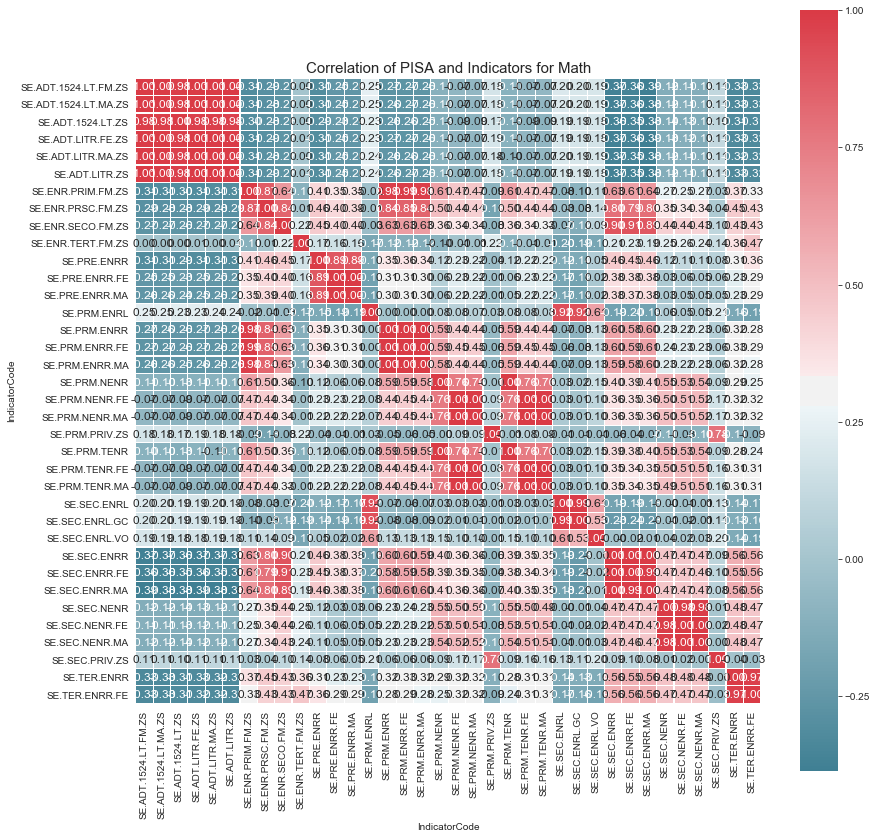

In [37]:
corr = education_pivot.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of PISA and Indicators for Math', y=1.05, size=15)
#take out FM and MA from indicators and see what the correlations are - might find more.  This one is for education, could look 
#at economony and employment

#### Just as anticipated, there is a lot of highly correlated data in here.  This has to do with indicators that are separated by male, female, and total.  To work through our model, let's remove any indicators (for all 3 E's) that are separated by male and female.  We will focus on indicators for 'total' for our project.

In [38]:
education_math.IndicatorCode.unique()

array(['SE.PRM.ENRL', 'SE.SEC.ENRL', 'SE.SEC.ENRL.GC', 'SE.SEC.ENRL.VO',
       'SE.PRE.ENRR', 'SE.PRE.ENRR.FE', 'SE.PRE.ENRR.MA', 'SE.SEC.ENRR',
       'SE.SEC.ENRR.FE', 'SE.ENR.SECO.FM.ZS', 'SE.SEC.ENRR.MA',
       'SE.TER.ENRR', 'SE.TER.ENRR.FE', 'SE.ENR.TERT.FM.ZS',
       'SE.TER.ENRR.MA', 'SE.PRM.PRIV.ZS', 'SE.SEC.PRIV.ZS',
       'SE.PRM.TENR', 'SE.PRM.TENR.FE', 'SE.PRM.TENR.MA', 'SE.PRM.ENRR',
       'SE.PRM.ENRR.FE', 'SE.ENR.PRIM.FM.ZS', 'SE.PRM.ENRR.MA',
       'SE.PRM.NENR', 'SE.PRM.NENR.FE', 'SE.PRM.NENR.MA',
       'SE.ENR.PRSC.FM.ZS', 'SE.SEC.NENR', 'SE.SEC.NENR.FE',
       'SE.SEC.NENR.MA', 'SE.ADT.LITR.ZS', 'SE.ADT.LITR.FE.ZS',
       'SE.ADT.LITR.MA.ZS', 'SE.ADT.1524.LT.ZS', 'SE.ADT.1524.LT.FE.ZS',
       'SE.ADT.1524.LT.FM.ZS', 'SE.ADT.1524.LT.MA.ZS'], dtype=object)

#### The indicator codes don't really make a lot of sense do they?  Let's rename them so that they describe what the codes mean.  This will make my models more relevant.

In [83]:
#Heather - need help in removing indicator codes that are for Female and Male - I am trying to do this via python but keep on hitting a roadblock.
#education_math_clean = education_math.IndicatorCode.drop(['SE.PRE.ENRR.FE', 'SE.PRE.ENRR.MA', 
       #'SE.SEC.ENRR.FE','SE.SEC.ENRR.MA','SE.TER.ENRR.FE', 'SE.TER.ENRR.MA',
       #'SE.PRM.TENR.FE', 'SE.PRM.TENR.MA','SE.PRM.ENRR.FE', 'SE.PRM.ENRR.MA',
       #'SE.PRM.NENR.FE', 'SE.PRM.NENR.MA','SE.SEC.NENR.FE','SE.SEC.NENR.MA', 'SE.ADT.LITR.FE.ZS',
       #'SE.ADT.LITR.MA.ZS','SE.ADT.1524.LT.FE.ZS','SE.ADT.1524.LT.MA.ZS'], axis = 0, inplace = True) 

In [92]:
rf_education['IndicatorCode'].replace({'SE.PRM.ENRL':'Primary School Enrollment', 'SE.SEC.ENRL':'Secondary School Enrollment'})

7696                   SE.ADT.LITR.ZS
7697                SE.ADT.LITR.FE.ZS
7698                SE.ADT.LITR.MA.ZS
7875        Primary School Enrollment
7876      Secondary School Enrollment
7877                   SE.SEC.ENRL.GC
7878                   SE.SEC.ENRL.VO
7988                      SE.PRE.ENRR
7989                   SE.PRE.ENRR.FE
7990                   SE.PRE.ENRR.MA
7991                      SE.TER.ENRR
7992                   SE.TER.ENRR.FE
7993                SE.ENR.TERT.FM.ZS
7994                   SE.TER.ENRR.MA
8321                   SE.PRM.PRIV.ZS
8322                   SE.SEC.PRIV.ZS
8624                SE.ADT.1524.LT.ZS
8625             SE.ADT.1524.LT.FE.ZS
8626             SE.ADT.1524.LT.FM.ZS
8627             SE.ADT.1524.LT.MA.ZS
12719       Primary School Enrollment
12720     Secondary School Enrollment
12721                  SE.SEC.ENRL.GC
12722                  SE.SEC.ENRL.VO
12835                     SE.PRE.ENRR
12836                  SE.PRE.ENRR.FE
12837       

In [93]:
education_pisa_math = pd.pivot_table(data = rf_education, index=['Country','Year'],values='PISA Score Average', fill_value = 0,aggfunc=np.mean)
education_pisa_math

PISA Score Average
Country                                            Year                    
Albania                                            2009                 377
                                                   2012                 394
Australia                                          2003                 524
                                                   2006                 520
                                                   2009                 514
                                                   2012                 504
Austria                                            2003                 506
                                                   2006                 505
                                                   2009                 496
                                                   2012                 506
Belgium                                            2003                 529
                                                   2006                 520
                                                   2009                 515
                                                   2012                 515
Brazil                                             2003                 356
                                                   2006                 370
                                                   2009                 386
                                                   2012                 389
Bulgaria                                           2006                 413
                                                   2009                 428
                                                   2012                 439
Canada                                             2006                 527
                                                   2009                 527
                                                   2012                 518
Chile                                              2006                 411
                                                   2009                 421
                                                   2012                 423
Colombia                                           2006                 370
                                                   2009                 381
                                                   2012                 376
...                                                                     ...
Switzerland                                        2006                 530
                                                   2009                 534
                                                   2012                 531
Thailand                                           2003                 417
                                                   2006                 417
                                                   2009                 419
                                                   2012                 427
Trinidad and Tobago                                2009                 414
Tunisia                                            2003                 359
                                                   2006                 365
                                                   2009                 371
                                                   2012                 388
Turkey                                             2003                 423
                                                   2006                 424
                                                   2009                 445
                                                   2012                 448
United Arab Emirates                               2012                 434
United Kingdom of Great Britain and Northern Ir... 2003                 508
                                                   2006                 495
                                                   2009                 492
                             

In [97]:
#indices

### Random Forest

In [98]:
from sklearn.ensemble import RandomForestRegressor

df1 = rf_education
y = education_pisa_math
X = education_pivot
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

radm = RandomForestRegressor()
radm.fit(Xtrain, ytrain)

reg = radm
indices = np.argsort(radm.feature_importances_)[::-1]

print('Feature ranking:')

for f in range(len(indices)):
    print('%d. feature %d %s (%f)' % (f+1 , 
                                      indices[f], 
                                      X.columns[indices[f]], 
                                      radm.feature_importances_[indices[f]]))

Feature ranking:
1. feature 30 SE.SEC.ENRR.MA (0.368837)
2. feature 28 SE.SEC.ENRR (0.135782)
3. feature 10 SE.ENR.TERT.FM.ZS (0.057957)
4. feature 11 SE.PRE.ENRR (0.056095)
5. feature 7 SE.ENR.PRIM.FM.ZS (0.046643)
6. feature 21 SE.PRM.PRIV.ZS (0.031197)
7. feature 29 SE.SEC.ENRR.FE (0.025928)
8. feature 13 SE.PRE.ENRR.MA (0.024008)
9. feature 25 SE.SEC.ENRL (0.023160)
10. feature 2 SE.ADT.1524.LT.MA.ZS (0.021297)
11. feature 35 SE.TER.ENRR (0.018510)
12. feature 3 SE.ADT.1524.LT.ZS (0.017657)
13. feature 36 SE.TER.ENRR.FE (0.016643)
14. feature 23 SE.PRM.TENR.FE (0.013358)
15. feature 37 SE.TER.ENRR.MA (0.012495)
16. feature 16 SE.PRM.ENRR.FE (0.011506)
17. feature 15 SE.PRM.ENRR (0.011482)
18. feature 17 SE.PRM.ENRR.MA (0.010613)
19. feature 34 SE.SEC.PRIV.ZS (0.010283)
20. feature 33 SE.SEC.NENR.MA (0.010014)
21. feature 26 SE.SEC.ENRL.GC (0.008627)
22. feature 9 SE.ENR.SECO.FM.ZS (0.007311)
23. feature 12 SE.PRE.ENRR.FE (0.006939)
24. feature 5 SE.ADT.LITR.MA.ZS (0.006600)
25. fea

In [99]:
radm.score(Xtest,ytest)

0.16982656347823444

### Linear Regression

In [100]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#training
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [101]:
#Keep in mind that i have male and female and adding them together equals the total - so already have multi-collinearity
mlregr.coef_

array([[ 3.42295458e+01, -1.84804042e+03, -1.31547727e+01,
         4.76168669e-02, -5.48474917e+01, -4.72760536e+01,
         9.95213371e+01,  3.27106055e+02, -1.43948369e+01,
        -1.81721350e+02,  7.07419731e+00,  1.09183417e-01,
        -5.10293550e+00,  5.11014494e+00, -3.73031389e-06,
        -4.59587289e+02,  2.20357330e+02,  2.36786323e+02,
         2.86616405e-01,  1.86757851e+01, -2.30159619e+01,
        -2.31114774e+00, -4.53584359e-01, -2.23900389e+01,
         2.67609849e+01,  2.51173693e-05, -2.23696899e-05,
        -2.20811109e-05,  1.91353825e+01, -7.58855394e+00,
        -9.91601563e+00,  3.24200203e-01,  1.86277081e+00,
        -2.11930830e+00,  1.81335238e+00,  8.95921796e+00,
        -4.71180586e+00, -3.79659689e+00]])

In [103]:
mlregr.score(Xtest,ytest) 

0.16896630746637264

In [104]:
Xtrain.shape
#Should select fewer features when running the models.  Right now, it's assuming basically a 1:1 ratio.  The other models would help.


(152, 38)

In [105]:
#training
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Support Vector Regression

In [106]:
rf_education.head()

,Country,Region,Sub Region,Year,subject_math,IndicatorCodeValue,IndicatorCode,PISA Score Average,primary_ed_enroll,secondary_ed_enroll,secondary_vocational_enroll
7696,Albania,Europe,Southern Europe,2012,1,97.247,SE.ADT.LITR.ZS,394.000,0,0,0
7697,Albania,Europe,Southern Europe,2012,1,96.136,SE.ADT.LITR.FE.ZS,394.000,0,0,0
7698,Albania,Europe,Southern Europe,2012,1,98.353,SE.ADT.LITR.MA.ZS,394.000,0,0,0
7875,Albania,Europe,Southern Europe,2012,1,206617.000,SE.PRM.ENRL,394.000,1,0,0
7876,Albania,Europe,Southern Europe,2012,1,349269.000,SE.SEC.ENRL,394.000,0,1,0


In [108]:
rf_education.columns

Index(['Country', 'Region', 'Sub Region', 'Year', 'subject_math',
       'IndicatorCodeValue', 'IndicatorCode', 'PISA Score Average',
       'primary_ed_enroll', 'secondary_ed_enroll',
       'secondary_vocational_enroll'],
      dtype='object')

In [116]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(Xtrain,ytrain)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

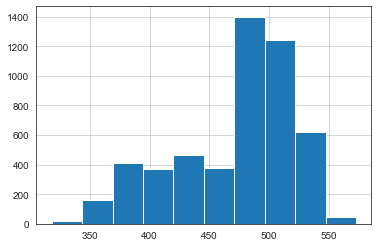

In [110]:
rf_education['PISA Score Average'].hist()
#can do a scatterplot, histogram of residuals - can compare actual data against what model is predicting - look at the histogram
#below, kind of showing the same issue as the recipe drill.

In [111]:
svr.score(Xtest,ytest)

-0.026740504620309524

### Lasso Regression

In [115]:
lass = linear_model.Lasso(alpha=.15)
#can pick the very best alpha to get the best score - can create a loop around the alpha to do (alpha = 1, alpha = .05)
lassfit = lass.fit(Xtrain, ytrain)
print('R² for the model with few features:')
print(lass.score(Xtrain, ytrain))
#also print out the score for the test set - that is what I should be validating against.  Training set helps to fit model
print(lass.score(Xtest, ytest))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

R² for the model with few features:
0.7006865880242039
0.34385166547626456

Parameter estimates for the model with few features:
[-1.44539048e+00 -0.00000000e+00 -7.03565865e-03  3.21043940e-02
  2.49036369e-01  1.36596051e+00 -2.22726556e-01  1.92760296e+02
 -5.52559092e+00 -1.71377294e+02  3.73562165e+00  1.84755179e-01
 -2.84130518e+00  2.81984420e+00 -2.80987159e-06 -9.85727408e-01
 -0.00000000e+00 -2.64839683e-01  4.86032921e-01 -7.06963747e-01
  6.11372502e-01 -1.48676471e+00 -6.75753801e-01 -9.56992212e-01
  1.10612687e+00  1.58818419e-05 -1.41524562e-05 -1.27471783e-05
  1.33987532e+00  8.55497248e-01 -6.95649972e-01  3.71810452e-01
  1.15439093e+00 -1.45437279e+00  1.15740860e+00  5.63772510e+00
 -3.20118107e+00 -1.98455762e+00  4.11681737e+02]


The R2 for our training set looks prety good, but our R2 for the test set is not as good.  This is indicative of overfitting.  Assumption is that there are a lot of features that are correlated to each other.

### Ridge Regression
#### Use Ridge Regression and Lasso Regression - instead of the Ridge Logistic Regression.  Ridge and Lasso regression will select features.

In [118]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)

In [119]:
pred_y_sklearn.flatten()

NameError: name 'pred_y_sklearn' is not defined

In [120]:
ytest.values.flatten()

array([388, 460, 518, 497, 506, 427, 523, 442, 370, 505, 494, 427, 410,
       427, 417, 483, 500, 423, 515, 548, 515, 476, 421, 547, 490, 407,
       471, 423, 501, 511, 487, 417, 510, 492, 509, 371, 531, 424, 520,
       409, 377, 389, 487, 527, 405, 503, 499, 432, 515, 495, 503, 495,
       391, 534, 485, 421, 541, 514, 536, 519, 483, 381, 493, 368, 491,
       394, 504, 501, 477, 542, 414, 482, 492, 478, 529, 406, 447, 459,
       495, 513, 522, 498, 370, 487, 490, 519, 494, 485, 419, 386, 506,
       386, 521, 466, 482])

In [121]:
ridge = linear_model.Ridge()
fit = ridge.fit(Xtrain, ytrain)

print('Coefficients')
print(pd.DataFrame(fit.coef_, columns=Xtest.columns))
print('\nIntercept:{}'.format(fit.intercept_))
    
print('\n Percentage accuracy training set')
print(ridge.score(Xtrain, ytrain))

print('\n Percentage accuracy testing set')
print(ridge.score(Xtest, ytest))

pred_y_sklearn = ridge.predict(Xtest)
print('\n Indicator Code and PISA Scores')
print(pd.crosstab(pred_y_sklearn.flatten(), ytest.values.flatten()))

Coefficients
IndicatorCode  SE.ADT.1524.LT.FE.ZS  SE.ADT.1524.LT.FM.ZS  \
0                           -11.544                -0.765   

IndicatorCode  SE.ADT.1524.LT.MA.ZS  SE.ADT.1524.LT.ZS  SE.ADT.LITR.FE.ZS  \
0                             5.504             -6.472              3.871   

IndicatorCode  SE.ADT.LITR.MA.ZS  SE.ADT.LITR.ZS  SE.ENR.PRIM.FM.ZS  \
0                          5.263           4.068             22.228   

IndicatorCode  SE.ENR.PRSC.FM.ZS  SE.ENR.SECO.FM.ZS  ...  SE.SEC.ENRR  \
0                          4.139            -89.216  ...       -0.170   

IndicatorCode  SE.SEC.ENRR.FE  SE.SEC.ENRR.MA  SE.SEC.NENR  SE.SEC.NENR.FE  \
0                       0.595          -0.008        0.402           3.181   

IndicatorCode  SE.SEC.NENR.MA  SE.SEC.PRIV.ZS  SE.TER.ENRR  SE.TER.ENRR.FE  \
0                      -3.475           2.137       -0.918           0.683   

IndicatorCode  SE.TER.ENRR.MA  
0                       1.050  

[1 rows x 38 columns]

Intercept:[455.00